# Time Series Analysis for sales prediction.

This notebook explores and builds a model to predict sales revenue based on various features. Initial model only considers the total sales for a particular date and the date of the sales.

## Aim:
Predict the total sales for a given period (daily, weekly or monthly)

## Dataset:
The dataset contains the following features:
- `Date`: Daily records from [start_date] to [end_date].
- `Store ID` & `Product ID`: Unique identifiers for stores and products.
- `Category`: Product categories like Electronics, Clothing, Groceries, etc.
- `Region`: Geographic region of the store.
- `Inventory Level`: Stock available at the beginning of the day.
- `Units Sold`: Units sold during the day.
- `Price`: Price of a unit of product sold.
- `Discount`: Discount given for a particular sale.
- `Demand Forecast`: Predicted demand based on past trends.
- `Weather Condition`: Daily weather impacting sales.
- `Holiday/Promotion`: Indicators for holidays or promotions.

Units Ordered,Demand Forecast,,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality

A simple ARIMA model would be created for forecasting the total (aggregated) sales for each day. This would serve as a baseline to evaluate the performance of subsequent models.

In [45]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

In [60]:
import pickle
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# Import data
df = pd.read_csv("../data/retail_store_inventory.csv")

# Display basic info
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [4]:
# Check for null values 
df.isnull().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

The data appears clean and there are no null values, hence no need to drop rows.
For a simple ARIMA model as baseline, the sales data would be aggregated for each day

In [ ]:
# Calculate total for each sale
df["adjusted_sales"] = df["Units Sold"] * df["Price"] * (1 - df["Discount"] / 100)

In [ ]:
# Aggregate sales by day and reset index
daily_sales = df.groupby("Date")["adjusted_sales"].sum().reset_index()
daily_sales.rename(columns={"adjusted_sales": "total_sales"}, inplace=True)
daily_sales = daily_sales.sort_values("Date")

In [ ]:
# Convert Date field to a DateTime format
daily_sales["Date"] = pd.to_datetime(daily_sales["Date"])
daily_sales.set_index("Date", inplace=True)
daily_sales = daily_sales.asfreq("D")


In [ ]:
# Check for null values in aggregated data
daily_sales.isnull().sum()

total_sales    0
dtype: int64

With no null values in the aggregated data, we can go on straight forward to exploring the data and building the model, without worry about NaN values

## Explore

The daily sales time series data is plotted to show the trends in daily sales data

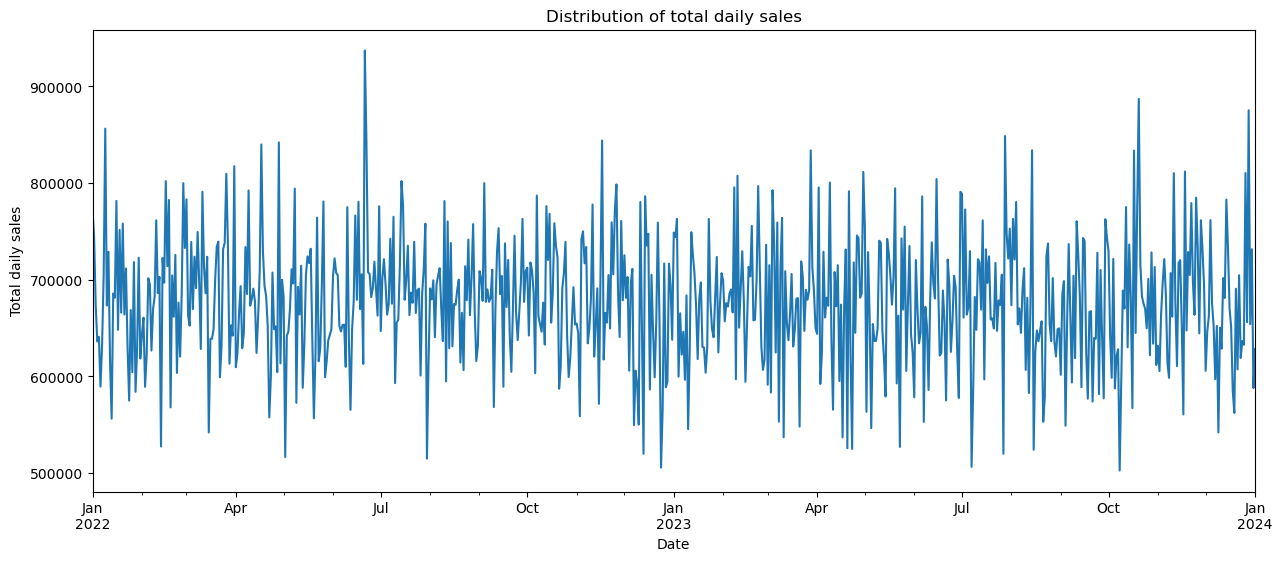

In [27]:
# Distribution of `daily_sales`
fig, ax = plt.subplots(figsize=(15, 6))
daily_sales["total_sales"].plot(ax=ax)
plt.ylabel("Total daily sales")
plt.title("Distribution of total daily sales")
plt.show();

We use a rolling average to draw a more intuitive visualization

<Axes: xlabel='Date', ylabel='Weekly Sales'>

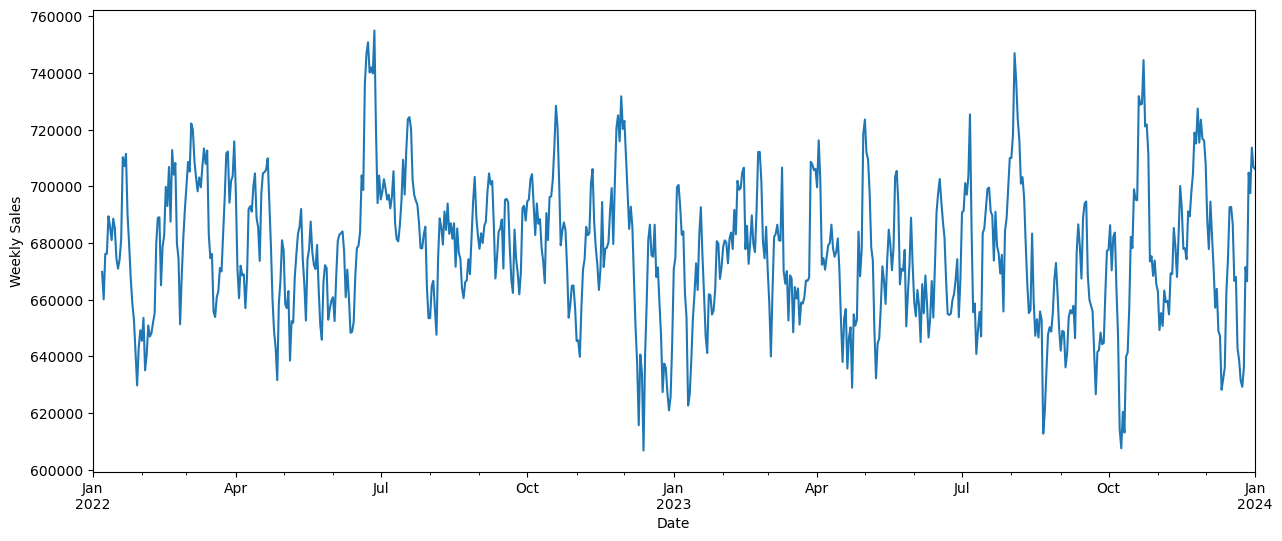

In [ ]:
# Using a rolling window of 7 days (or 1 week)
fig, ax = plt.subplots(figsize=(15, 6))
daily_sales["total_sales"].rolling(7).mean().plot(ax=ax,ylabel="Weekly Sales")

This gives a better visualization. We proceed to split our data into a training and test set.

## Train-Test split

In [32]:
# Split data into training and test set
cutoff = int(0.8 * len(daily_sales))
train = daily_sales.iloc[:cutoff]
test = daily_sales.iloc[cutoff:]

In [33]:
train["total_sales"]

Date
2022-01-01    772789.6240
2022-01-02    743864.0160
2022-01-03    673213.6870
2022-01-04    635959.5460
2022-01-05    640787.6075
                 ...     
2023-08-03    720919.5370
2023-08-04    780432.3135
2023-08-05    653724.1605
2023-08-06    670171.2095
2023-08-07    644883.4285
Freq: D, Name: total_sales, Length: 584, dtype: float64

## Build Baseline model

In [48]:
# Fit ARIMA model (p,d,q = (5,1,0) as a start)
model = ARIMA(train["total_sales"], order=(5,1,0))
model_fit = model.fit()

# Make forecast
forecast = model_fit.forecast(steps=len(test))

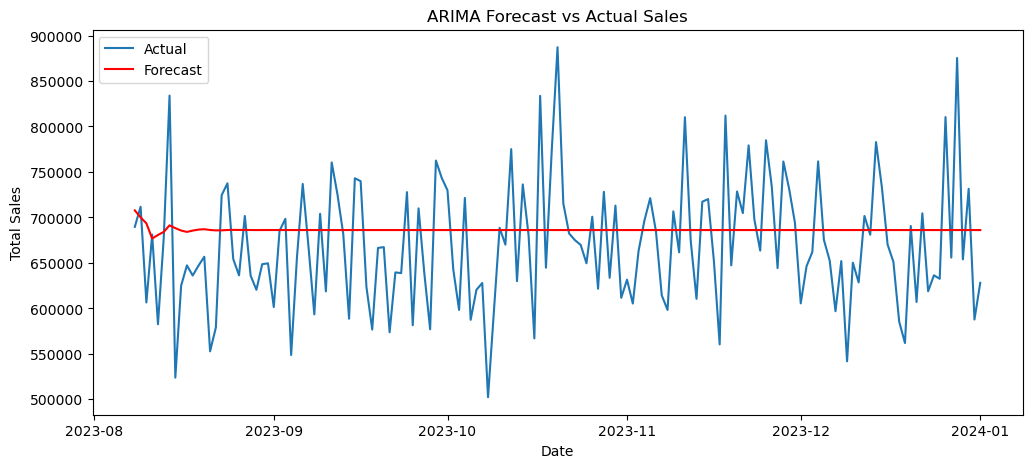

In [49]:
# Static forecast
plt.figure(figsize=(12, 5))
# plt.plot(train.index, train["total_sales"], label="Train")
plt.plot(test.index, test["total_sales"], label="Actual")
plt.plot(test.index, forecast, label="Forecast", color="red")
plt.title("ARIMA Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.show()

In [50]:
# Calculating forecast errors
base_model_rmse = np.sqrt(mean_squared_error(test["total_sales"], forecast))
print(f"Base model static forecast RMSE: {base_model_rmse:.2f}")

Base model static forecast RMSE: 70842.36


The forecast looks fairly constant, with considerable large root mean square error. Using a walkforward validation provides a better forecast.

In [51]:
# Performing walk forward validation on base model
history = list(train["total_sales"])
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test["total_sales"].iloc[t])

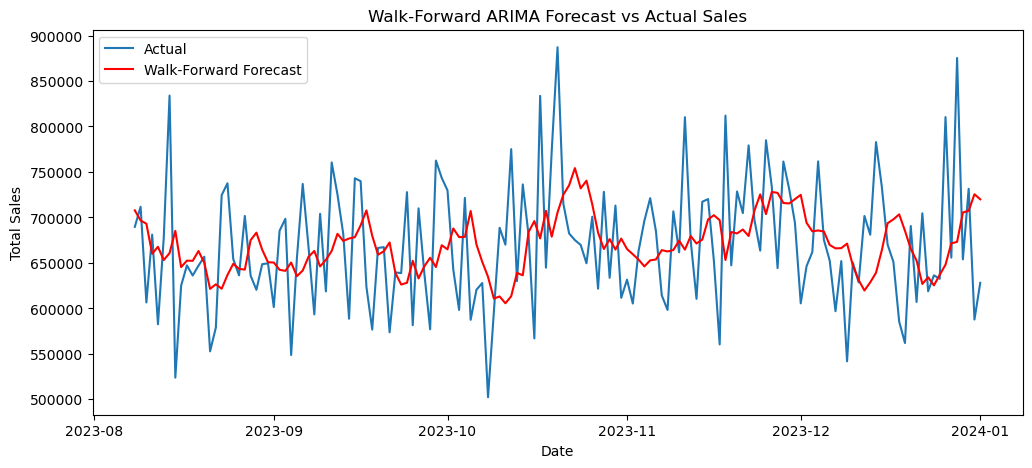

In [54]:
# Plotting walk-forward forecast
plt.figure(figsize=(12, 5))
plt.plot(test.index, test["total_sales"], label="Actual")
plt.plot(test.index, predictions, label="Walk-Forward Forecast", color="red")
plt.title("Walk-Forward ARIMA Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.show()

This performed better than a static forecast. Now we calculate the performance based on error metrics.

In [53]:
# Calcuate forecast error
base_model_rmse = np.sqrt(mean_squared_error(test["total_sales"], predictions))
print(f"Base model walk-forward RMSE: {base_model_rmse:.2f}")

Base model walk-forward RMSE: 74464.67


In [57]:
# Save model as pickle file
with open("../models/arima_5_1_0.pkl", "wb") as file:
    pickle.dump(model_fit, file)

## Rebuild ARIMA model with new parameters

Let's determine the best parameters for our ARIMA model

In [62]:
# Determine the "d" parameter
result = adfuller(daily_sales["total_sales"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -27.46396653655649
p-value: 0.0


With the `p-value` here being `0 (< 0.05)`, the data is stationary, and hence `d = 0`. We move on to determine `p` and `q`.

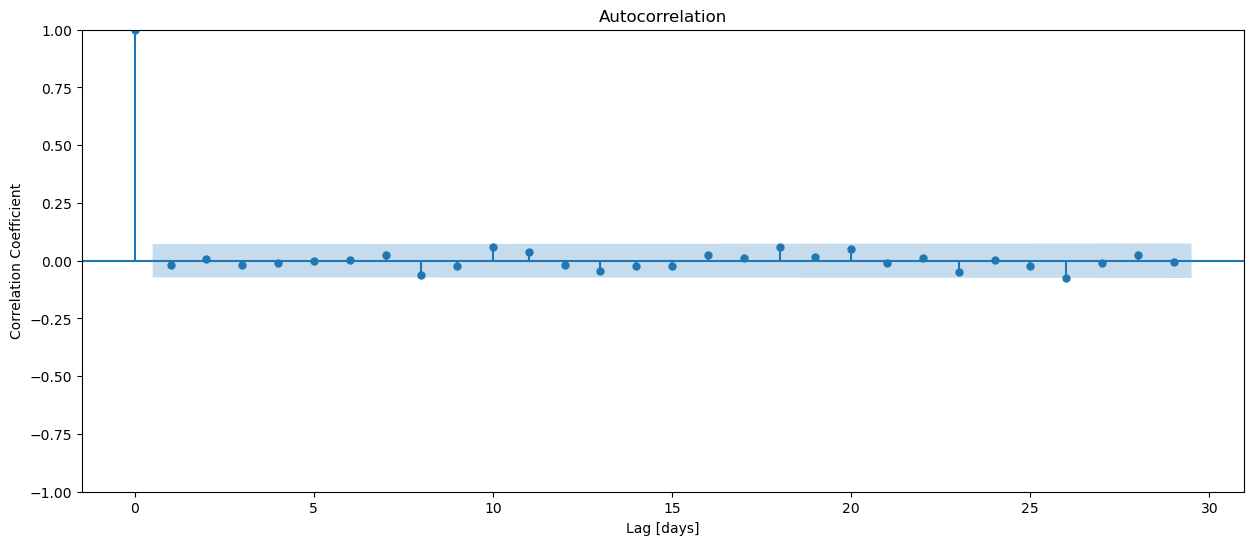

In [69]:
# ACF plot to determine `p`
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(daily_sales["total_sales"],ax=ax)
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

c:\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


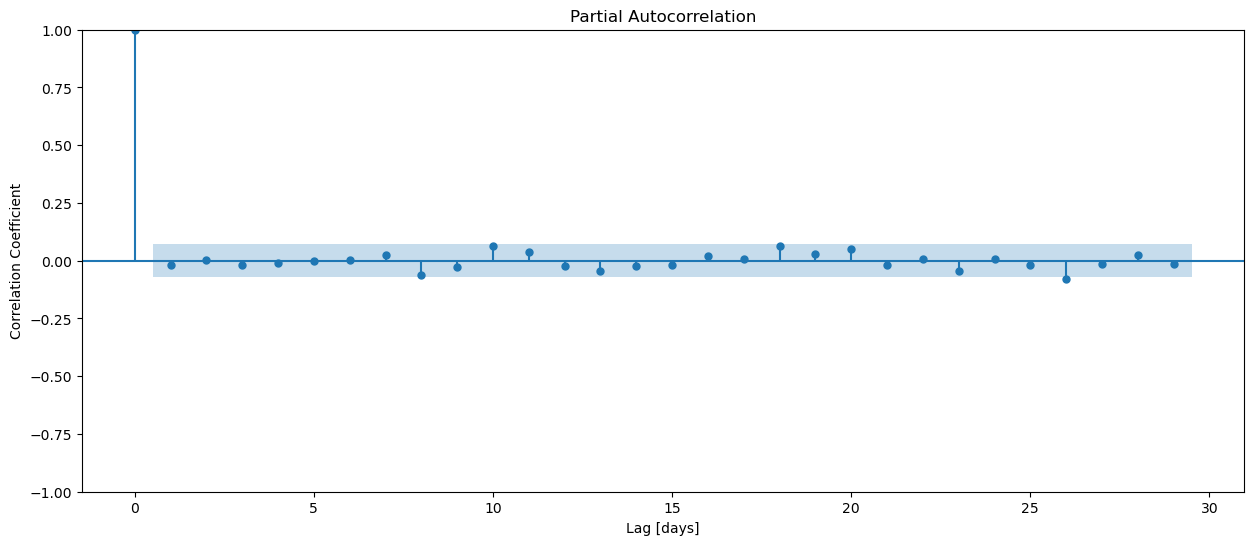

In [65]:
# ACF plot to determine `p`
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(daily_sales["total_sales"],ax=ax)
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

In [ ]:
# Create final model with order (0,0,0)
model = ARIMA(train["total_sales"], order=(5,1,0))
model_fit = model.fit()

This notebook and its contents are intended for educational purposes only. Feel free to explore.